In [1]:
import sys
import importlib
import gc
import glob
import random

from itertools import combinations

import numpy as np
import sklearn
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import pyemma
import msmtools
import mdtraj as md
import MDAnalysis as mda
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis

import ivac
import extq

sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


In [2]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots

cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

In [3]:
traj_files = np.loadtxt("../../data/suppl_traj_files.txt", dtype=str)

In [4]:
from scipy import signal

In [5]:
def moving_average(x, w):
    return signal.convolve(x, np.ones(w) / w, mode='same')

# Testing

In [6]:
mda.__version__

'2.0.0'

In [7]:
# top = mda.topology.TOPParser.TOPParser("../../unbiased/000/civsd.prmtop")
u = mda.Universe("../../models/Initial-models/civsd.psf", traj_files[0])

In [8]:
r217_sel = "protein and resid 217 and not backbone"
phos_sel = "name O11 O12 O13 O14 and around 4.0 (protein and resid 217)"
# hb = HydrogenBondAnalysis(
#     traj, 
#     donors_sel=r217_sel, 
#     hydrogens_sel=None, 
#     acceptors_sel=phos_sel, 
#     d_a_cutoff=4.0, 
#     update_selections=True)
hb = HydrogenBondAnalysis(
    universe=u,
    between=[r217_sel, phos_sel],
    update_selections=True)

In [9]:
for a in u.select_atoms(r217_sel):
    print(a)


<Atom 1768: HN of type H of resname ARG, resid 217 and segid A>
<Atom 1770: HA of type HB1 of resname ARG, resid 217 and segid A>
<Atom 1771: CB of type CT2 of resname ARG, resid 217 and segid A>
<Atom 1772: HB1 of type HA2 of resname ARG, resid 217 and segid A>
<Atom 1773: HB2 of type HA2 of resname ARG, resid 217 and segid A>
<Atom 1774: CG of type CT2 of resname ARG, resid 217 and segid A>
<Atom 1775: HG1 of type HA2 of resname ARG, resid 217 and segid A>
<Atom 1776: HG2 of type HA2 of resname ARG, resid 217 and segid A>
<Atom 1777: CD of type CT2 of resname ARG, resid 217 and segid A>
<Atom 1778: HD1 of type HA2 of resname ARG, resid 217 and segid A>
<Atom 1779: HD2 of type HA2 of resname ARG, resid 217 and segid A>
<Atom 1780: NE of type NC2 of resname ARG, resid 217 and segid A>
<Atom 1781: HE of type HC of resname ARG, resid 217 and segid A>
<Atom 1782: CZ of type C of resname ARG, resid 217 and segid A>
<Atom 1783: NH1 of type NC2 of resname ARG, resid 217 and segid A>
<Atom 17

In [11]:
for a in u.select_atoms(phos_sel, updating=True):
    print(a)

<Atom 21937: O14 of type O2L of resname POPC, resid 23 and segid L13>
<Atom 21938: O12 of type OSLP of resname POPC, resid 23 and segid L13>
<Atom 21939: O11 of type OSLP of resname POPC, resid 23 and segid L13>


In [31]:
hb.run()

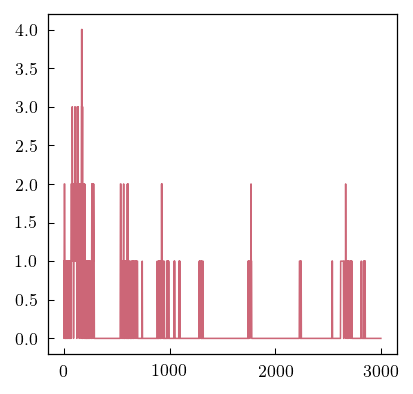

In [38]:
plt.plot(hb.count_by_time())

In [39]:
hb.count_by_type()

array([['ARG:NC2', 'POPC:O2L', '660'],
       ['ARG:NC2', 'POPC:OSLP', '40']], dtype='<U21')

In [64]:
hb.count_by_ids()

array([[ 1785,  1786,  2615,   154],
       [ 1785,  1787,  2615,   122],
       [ 1785,  1786, 21935,   117],
       [ 1779,  1780,  2615,    70],
       [ 1785,  1787, 21935,    60],
       [ 1785,  1786, 21936,    58],
       [ 1782,  1783,  2615,    36],
       [ 1782,  1783, 21935,    31],
       [ 1785,  1786, 21938,    28],
       [ 1782,  1783, 21936,    12],
       [ 1785,  1786, 21937,     7],
       [ 1782,  1783, 21938,     3],
       [ 1785,  1787, 21938,     2]])

In [12]:
r217_sel = "protein and resid 217 and type NC2"
for a in u.select_atoms(r217_sel):
    print(a)

<Atom 1780: NE of type NC2 of resname ARG, resid 217 and segid A>
<Atom 1783: NH1 of type NC2 of resname ARG, resid 217 and segid A>
<Atom 1786: NH2 of type NC2 of resname ARG, resid 217 and segid A>


In [63]:
hbonds = HydrogenBondAnalysis(
    universe=u, 
    donors_sel=r217_sel, 
    hydrogens_sel=None, 
    acceptors_sel=phos_sel, 
    d_a_cutoff=4.0, 
    update_selections=True)
hbonds.run()

In [65]:
hbonds.count_by_type()

array([['ARG:NC2', 'POPC:O2L', '2214'],
       ['ARG:NC2', 'POPC:OSLP', '694']], dtype='<U21')

In [69]:
u.atoms[12580]

<Atom 12581: O13 of type O2L of resname POPC, resid 13 and segid L12>

In [66]:
hbonds.count_by_ids()

array([[ 1782,  1783, 20461,   175],
       [ 1782,  1783,  2614,   165],
       [ 1785,  1786,  2614,   160],
       [ 1785,  1786,  2615,   157],
       [ 1779,  1780, 28194,   148],
       [ 1782,  1783,  2617,   133],
       [ 1785,  1787,  2615,   128],
       [ 1785,  1787,  2614,   121],
       [ 1785,  1786, 21935,   119],
       [ 1785,  1786, 20461,    90],
       [ 1785,  1786,  2616,    85],
       [ 1779,  1780,  2615,    80],
       [ 1782,  1783, 20462,    72],
       [ 1779,  1780,  2614,    71],
       [ 1782,  1783, 20464,    64],
       [ 1785,  1787, 28194,    63],
       [ 1785,  1787, 21935,    62],
       [ 1785,  1786, 21936,    61],
       [ 1779,  1780, 28197,    57],
       [ 1785,  1786, 20462,    56],
       [ 1779,  1780, 28196,    51],
       [ 1782,  1783, 12580,    49],
       [ 1785,  1786,  2617,    47],
       [ 1785,  1787, 20461,    47],
       [ 1785,  1787,  2616,    46],
       [ 1782,  1783,  3153,    44],
       [ 1785,  1787, 28196,    44],
 

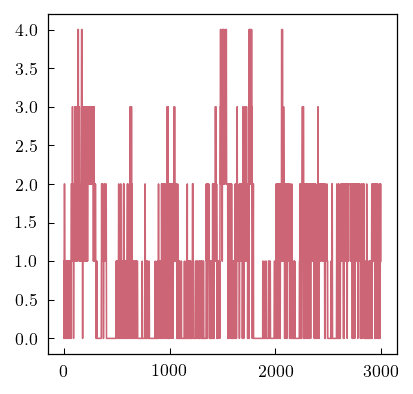

In [67]:
plt.plot(hbonds.count_by_time())

In [72]:
# r217_sel = "protein and resid 217 and not backbone"
phos_sel = "name O11 O12 O13 O14 and around 3.0 (protein and resid 217)"
hbonds_short = HydrogenBondAnalysis(
    universe=u, 
    donors_sel=r217_sel, 
    hydrogens_sel=None, 
    acceptors_sel=phos_sel, 
    update_selections=True)
hbonds_short.run()

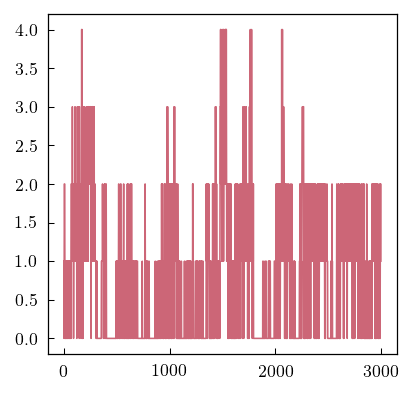

In [73]:
plt.plot(hbonds_short.count_by_time())

In [74]:
hbonds_short.count_by_type()

array([['ARG:NC2', 'POPC:O2L', '2101'],
       ['ARG:NC2', 'POPC:OSLP', '552']], dtype='<U21')

In [75]:
hbonds_short.results.hbonds[0]

array([0.00000000e+00, 1.78500000e+03, 1.78600000e+03, 2.19380000e+04,
       2.81756459e+00, 1.71197253e+02])

In [52]:
u.atoms[21938]

<Atom 21939: O11 of type OSLP of resname POPC, resid 23 and segid L13>

In [56]:
r217_sel = "protein and resid 217 and not backbone"
phos_sel_short = "name O11 O12 O13 O14 and around 3.0 (protein and resid 217)"
hbonds_short_2 = HydrogenBondAnalysis(
    universe=u, 
    donors_sel=r217_sel, 
    hydrogens_sel=None, 
    acceptors_sel=phos_sel_short, 
    update_selections=True)
hbonds_short_2.run()

KeyboardInterrupt: 

# Parallelize computation

In [13]:
from multiprocessing import cpu_count
from joblib import Parallel, delayed
n_jobs = cpu_count()

In [14]:
def hbond_traj(trajfile):
    u = mda.Universe("../../models/Initial-models/civsd.psf", trajfile)
    r217_sel = "protein and resid 217 and type NC2"
    phos_sel = "name O11 O12 O13 O14 and around 3.0 (protein and resid 217)"
    hbonds = HydrogenBondAnalysis(
        universe=u, 
        donors_sel=r217_sel, 
        hydrogens_sel=None, 
        acceptors_sel=phos_sel,
        update_selections=True)
    return hbonds
        
def run_analysis(analysis):
    analysis.run()
    return analysis.count_by_time()

In [15]:
analysis_ensemble = [hbond_traj(file) for file in traj_files]

KeyboardInterrupt: 

In [79]:
len(analysis_ensemble)

244

In [80]:
results_ensemble = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   5 tasks      | elapsed:  3.4min
[Parallel(n_jobs=40)]: Done  18 tasks      | elapsed:  3.8min
[Parallel(n_jobs=40)]: Done  33 tasks      | elapsed:  4.4min
[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:  6.9min
[Parallel(n_jobs=40)]: Done  65 tasks      | elapsed:  7.4min
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:  9.9min
[Parallel(n_jobs=40)]: Done 101 tasks      | elapsed: 10.9min
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed: 11.7min
[Parallel(n_jobs=40)]: Done 141 tasks      | elapsed: 14.4min
[Parallel(n_jobs=40)]: Done 162 tasks      | elapsed: 17.1min
[Parallel(n_jobs=40)]: Done 190 out of 244 | elapsed: 18.4min remaining:  5.2min
[Parallel(n_jobs=40)]: Done 215 out of 244 | elapsed: 21.3min remaining:  2.9min
[Parallel(n_jobs=40)]: Done 240 out of 244 | elapsed: 22.1min remaining:   22.1s
[Parallel(n_jobs=40)]: Done 244 out of 244 | elapsed: 23.2mi

In [85]:
len(results_ensemble), results_ensemble[0].shape

(244, (3000,))

In [115]:
np.save("../../data/raw_feat/cv_hbond_r0P_suppl.npy", results_ensemble)

(array([210143.,      0.,      0.,      0., 251194.,      0.,      0.,
             0., 189066.,      0.,      0.,      0.,  66223.,      0.,
             0.,      0.,  14481.,      0.,      0.,    893.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

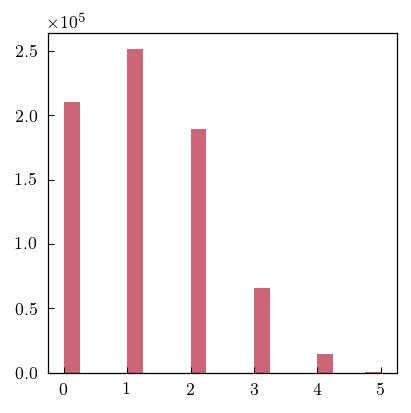

In [88]:
plt.hist(np.concatenate(results_ensemble), bins=20)

In [89]:
from scipy import signal

In [93]:
def moving_average(x, w):
    return signal.convolve(x, np.ones(w) / w, mode='same')

(0.0, 500.0)

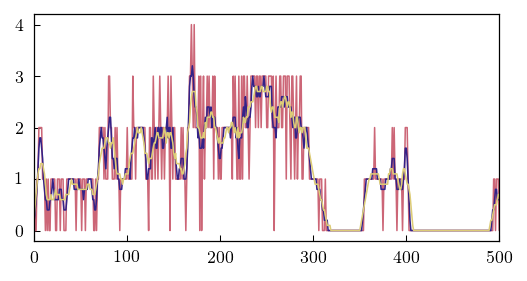

In [97]:
f = plt.figure(figsize=(4, 2))
plt.plot(results_ensemble[0])
plt.plot(moving_average(results_ensemble[0], 5))
plt.plot(moving_average(results_ensemble[0], 10))
plt.xlim([0, 500])

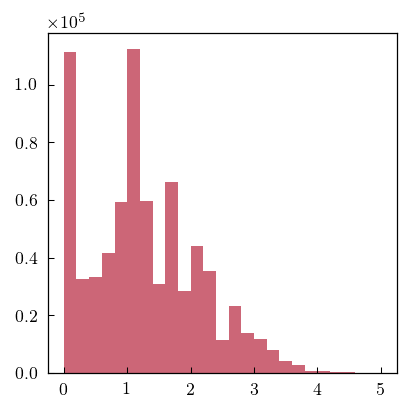

In [105]:
results_windowed = np.concatenate([moving_average(traj, 5) for traj in results_ensemble])
h = plt.hist(results_windowed, bins=np.linspace(0, 5, 26))

In [114]:
results_windowed.shape

(732000,)

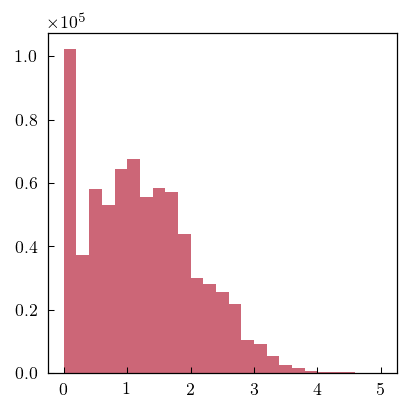

In [106]:
results_windowed = np.concatenate([moving_average(traj, 10) for traj in results_ensemble])
h = plt.hist(results_windowed, bins=np.linspace(0, 5, 26))

# R232/R4

In [107]:
def hbond_r4_analysis(trajfile):
    u = mda.Universe("../../models/Initial-models/civsd.psf", trajfile)
    r232_sel = "protein and resid 232 and type NC2"
    phos_sel = "name O11 O12 O13 O14 and around 3.0 (protein and resid 232)"
    hbonds = HydrogenBondAnalysis(
        universe=u, 
        donors_sel=r232_sel, 
        hydrogens_sel=None, 
        acceptors_sel=phos_sel,
        update_selections=True)
    return hbonds

In [110]:
test_r4 = hbond_r4_analysis(traj_files[0])
test_r4.run()

In [111]:
test_r4.count_by_ids()

array([[ 2054,  2055, 22606,  1388],
       [ 2057,  2058, 16469,   875],
       [ 2060,  2062, 22607,   832],
       [ 2060,  2061, 16467,   652],
       [ 2060,  2061, 16466,   412],
       [ 2060,  2062, 22606,   371],
       [ 2057,  2058, 16467,   199],
       [ 2057,  2058,  7843,   197],
       [ 2060,  2061,  7840,   157],
       [ 2060,  2061,  7841,   140],
       [ 2060,  2062,  7840,   104],
       [ 2057,  2058,  7841,   101],
       [ 2057,  2058,  7840,   100],
       [ 2054,  2055,  7840,    45],
       [ 2054,  2055, 22605,    43],
       [ 2057,  2058, 16466,    38],
       [ 2060,  2062, 22605,    28],
       [ 2060,  2062, 22608,    24],
       [ 2060,  2062,  7842,    14],
       [ 2060,  2061, 22606,     8],
       [ 2054,  2055,  7843,     7],
       [ 2060,  2062,  7841,     6],
       [ 2054,  2055, 22608,     6],
       [ 2060,  2061, 16468,     3],
       [ 2060,  2061, 16469,     3],
       [ 2060,  2062,  7843,     2],
       [ 2060,  2061,  7842,     2],
 

In [112]:
test_r4.count_by_type()

array([['ARG:NC2', 'POPC:O2L', '3794'],
       ['ARG:NC2', 'POPC:OSLP', '1966']], dtype='<U21')

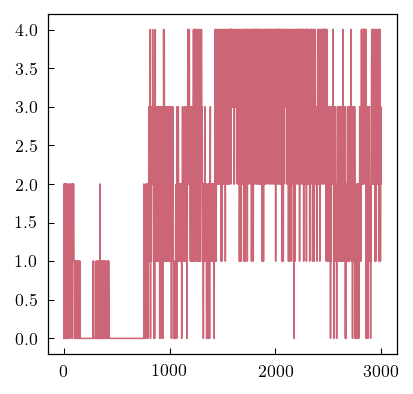

In [113]:
plt.plot(test_r4.count_by_time())

In [158]:
for i, j, k, _ in test_r4.count_by_ids():
    print(u.atoms[j])

<Atom 2056: HE of type H of resname ARG, resid 232 and segid A and altLoc >
<Atom 2059: HH11 of type H of resname ARG, resid 232 and segid A and altLoc >
<Atom 2063: HH22 of type H of resname ARG, resid 232 and segid A and altLoc >
<Atom 2062: HH21 of type H of resname ARG, resid 232 and segid A and altLoc >
<Atom 2062: HH21 of type H of resname ARG, resid 232 and segid A and altLoc >
<Atom 2063: HH22 of type H of resname ARG, resid 232 and segid A and altLoc >
<Atom 2059: HH11 of type H of resname ARG, resid 232 and segid A and altLoc >
<Atom 2059: HH11 of type H of resname ARG, resid 232 and segid A and altLoc >
<Atom 2062: HH21 of type H of resname ARG, resid 232 and segid A and altLoc >
<Atom 2062: HH21 of type H of resname ARG, resid 232 and segid A and altLoc >
<Atom 2063: HH22 of type H of resname ARG, resid 232 and segid A and altLoc >
<Atom 2059: HH11 of type H of resname ARG, resid 232 and segid A and altLoc >
<Atom 2059: HH11 of type H of resname ARG, resid 232 and segid A a

# Anton trajectories

In [163]:
u = mda.Universe("../../civsd-nowat.pdb", "../../anton2/nowat/civsd.nowat.3.dcd")

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [159]:
r217_sel = "protein and resid 217 and not backbone and type N"
phos_sel = "name O11 O12 O13 O14 and around 3.0 (protein and resid 217)"
h_sel = "protein and resid 217 and name HE HH11 HH21 HH22 HH12"
hbonds = HydrogenBondAnalysis(
    universe=u, 
    donors_sel=r217_sel, 
    hydrogens_sel=h_sel, 
    acceptors_sel=phos_sel,
    update_selections=True)

In [164]:
for a in u.select_atoms(r217_sel):
    print(a)

<Atom 1780: NE of type N of resname ARG, resid 217 and segid A and altLoc >
<Atom 1783: NH1 of type N of resname ARG, resid 217 and segid A and altLoc >
<Atom 1786: NH2 of type N of resname ARG, resid 217 and segid A and altLoc >


In [165]:
for a in u.select_atoms(phos_sel):
    print(a)

<Atom 4223: O13 of type O of resname POPC, resid 16 and segid L11 and altLoc >
<Atom 4225: O12 of type O of resname POPC, resid 16 and segid L11 and altLoc >
<Atom 16284: O14 of type O of resname POPC, resid 18 and segid L13 and altLoc >
<Atom 16285: O12 of type O of resname POPC, resid 18 and segid L13 and altLoc >


In [166]:
for a in u.select_atoms(h_sel):
    print(a)

<Atom 1781: HE of type H of resname ARG, resid 217 and segid A and altLoc >
<Atom 1784: HH11 of type H of resname ARG, resid 217 and segid A and altLoc >
<Atom 1785: HH12 of type H of resname ARG, resid 217 and segid A and altLoc >
<Atom 1787: HH21 of type H of resname ARG, resid 217 and segid A and altLoc >
<Atom 1788: HH22 of type H of resname ARG, resid 217 and segid A and altLoc >


In [141]:
u.atoms.positions[1783] - u.atoms.positions[16284]

1.6750025

In [142]:
from MDAnalysis.analysis import distances

In [151]:
distances.distance_array(u.atoms.positions[[1780, 1783, 1786]], u.atoms.positions[[4223, 4225, 16284, 16285]], box=u.dimensions)

array([[6.58802176, 5.54538281, 5.05318894, 6.69388579],
       [8.68815079, 8.40702869, 1.67500236, 3.61818665],
       [7.68366522, 7.81178879, 2.95260543, 3.76242839]])

In [167]:
hbonds.run()

In [168]:
hbonds.count_by_ids()

array([[ 1780,  1781, 11191,  2927],
       [ 1783,  1785, 11191,  1563],
       [ 1783,  1785, 11194,   513],
       [ 1783,  1784, 22314,   327],
       [ 1783,  1785,  3018,   321],
       [ 1783,  1784,  3018,   316],
       [ 1780,  1781, 11192,   279],
       [ 1783,  1784,  3822,   264],
       [ 1786,  1787, 15750,   244],
       [ 1786,  1787, 22314,   227],
       [ 1783,  1784, 21778,   223],
       [ 1783,  1784,  3821,   219],
       [ 1783,  1785,  3017,   214],
       [ 1783,  1784, 15747,   210],
       [ 1786,  1787,  3822,   210],
       [ 1783,  1785, 16284,   173],
       [ 1783,  1785, 16283,   170],
       [ 1786,  1787,  3018,   169],
       [ 1780,  1781,  3018,   165],
       [ 1786,  1787, 22313,   163],
       [ 1786,  1787, 21778,   161],
       [ 1783,  1785,  3020,   160],
       [ 1786,  1787,  3017,   155],
       [ 1780,  1781, 16283,   153],
       [ 1783,  1784,  2348,   150],
       [ 1786,  1787,  3821,   145],
       [ 1786,  1787, 15614,   138],
 

In [169]:
hbonds.count_by_type()

array([['ARG:N', 'POPC:O', '15065']], dtype='<U21')

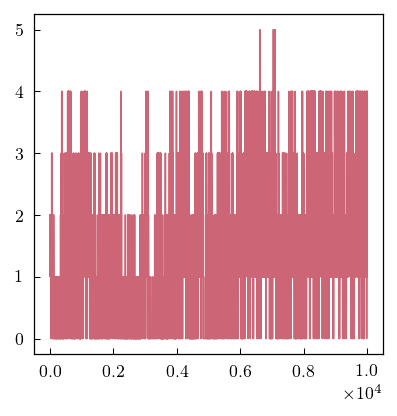

In [170]:
plt.plot(hbonds.count_by_time())

## run all

In [32]:
def hbond_anton(trajfile):
    u = mda.Universe("../../civsd-nowat.pdb", trajfile)
    r217_sel = "protein and resid 217 and not backbone and type N"
    phos_sel = "name O11 O12 O13 O14 and around 3.0 (protein and resid 217)"
    h_sel = "protein and resid 217 and name HE HH11 HH21 HH22 HH12"
    hbonds = HydrogenBondAnalysis(
        universe=u, 
        donors_sel=r217_sel, 
        hydrogens_sel=h_sel, 
        acceptors_sel=phos_sel,
        update_selections=True)
    return hbonds
        
def run_analysis(analysis):
    analysis.run()
    return analysis.count_by_time()

In [ ]:
dcd7 = md.load("../../anton2/nowat/civsd.nowat.7.dcd", top="../../unbiased/000/civsd.prmtop")

ValueError: The topology and the trajectory files might not contain the same atoms
The input topology must contain all atoms even if you want to select a subset of them with atom_indices

In [ ]:
dcd7.atom_slice(dcd7.topology.select("not water"))

<mdtraj.Trajectory with 10000 frames, 25547 atoms, 347 residues, and unitcells at 0x7ff7cc9002b0>

In [ ]:
dcd7.atom_slice(dcd7.topology.select("not water")).save_dcd("../../anton2/civsd.nowat.7.dcd")

In [27]:
dcds = [f"/project2/roux/scguo/ci-vsd/anton2/nowat/civsd.nowat.{i}.dcd" for i in range(3, 20)]
dcd_analysis_ensemble = [hbond_anton(file) for file in dcds]

NameError: name 'hbond_anton' is not defined

In [6]:
len(dcd_analysis_ensemble)

17

In [10]:
results_dcd = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in dcd_analysis_ensemble)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=40)]: Done   2 out of  17 | elapsed:  1.6min remaining: 12.3min
[Parallel(n_jobs=40)]: Done   3 out of  17 | elapsed:  1.6min remaining:  7.6min
[Parallel(n_jobs=40)]: Done   4 out of  17 | elapsed:  1.6min remaining:  5.3min
[Parallel(n_jobs=40)]: Done   5 out of  17 | elapsed:  1.6min remaining:  3.9min
[Parallel(n_jobs=40)]: Done   6 out of  17 | elapsed:  1.6min remaining:  3.0min
[Parallel(n_jobs=40)]: Done   7 out of  17 | elapsed:  1.6min remaining:  2.3min
[Parallel(n_jobs=40)]: Done   8 out of  17 | elapsed:  1.6min remaining:  1.8min
[Parallel(n_jobs=40)]: Done   9 out of  17 | elapsed:  1.6min remaining:  1.5min
[Parallel(n_jobs=40)]: Done  10 out of  17 | elapsed:  1.6min remaining:  1.2min
[Parallel(n_jobs=40)]: Done  11 out of  17 | elapsed:  1.6min remaining:   53.8s
[Parallel(n_jobs=40)]: Done  12 out of  17 | elapse

In [11]:
len(results_dcd), results_dcd[0].shape

(17, (10001,))

In [12]:
# np.save("../../data/raw_feat/cv_hbond_r0P_anton2.npy", results_dcd)

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [53]:
# fix trajectory civsd.nowat.7.dcd
print(dcds[4])
hb4 = hbond_anton(dcds[4])
hb4.run()

/project2/roux/scguo/ci-vsd/anton2/nowat/civsd.nowat.7.dcd


/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [55]:
hb4.count_by_time().shape

(10001,)

In [56]:
results_dcd[4] = hb4.count_by_time()

In [57]:
np.save("../../data/raw_feat/cv_hbond_r0P_anton2.npy", results_dcd)

(0.0, 500.0)

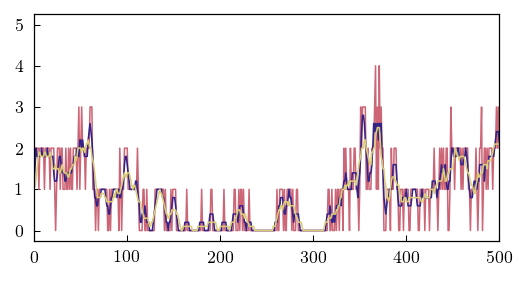

In [16]:
f = plt.figure(figsize=(4, 2))
plt.plot(results_dcd[0])
plt.plot(moving_average(results_dcd[0], 5))
plt.plot(moving_average(results_dcd[0], 10))
plt.xlim([0, 500])

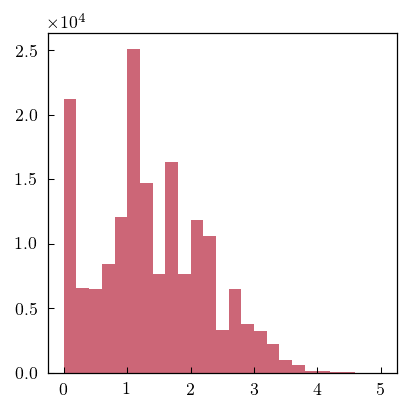

In [17]:
results_windowed = np.concatenate([moving_average(traj, 5) for traj in results_dcd])
h = plt.hist(results_windowed, bins=np.linspace(0, 5, 26))

In [18]:
results_windowed.shape

(170016,)

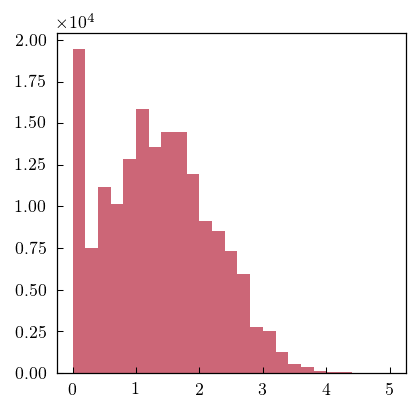

In [21]:
results_windowed = np.concatenate([moving_average(traj, 10) for traj in results_dcd])
h = plt.hist(results_windowed, bins=np.linspace(0, 5, 26))

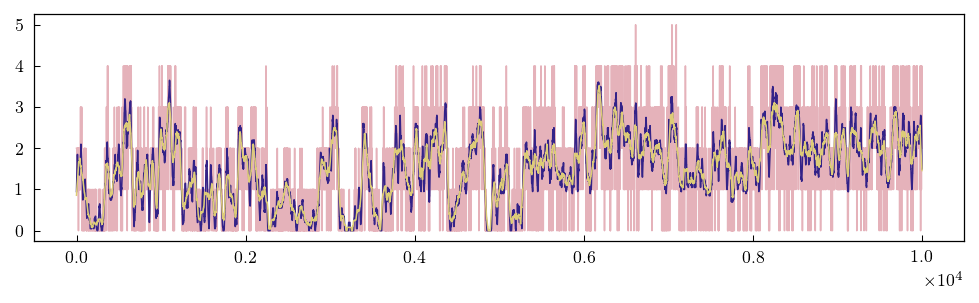

In [25]:
f = plt.figure(figsize=(8, 2))
plt.plot(results_dcd[0], alpha=0.5)
plt.plot(moving_average(results_dcd[0], 20))
plt.plot(moving_average(results_dcd[0], 50))
# plt.xlim([0, 500])

In [30]:
from scipy.ndimage import gaussian_filter1d

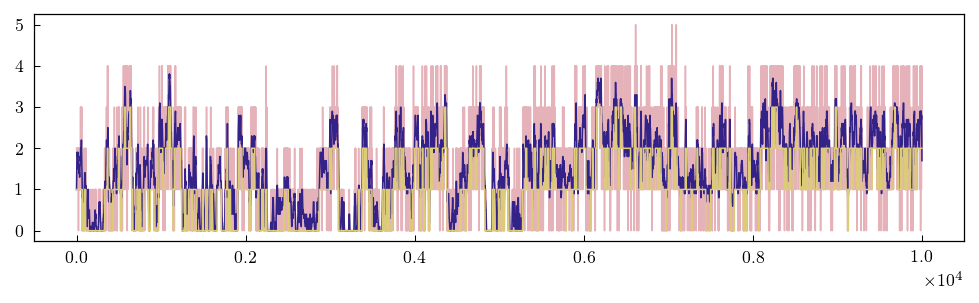

In [35]:
f = plt.figure(figsize=(8, 2))
plt.plot(results_dcd[0], alpha=0.5)
plt.plot(moving_average(results_dcd[0], 10))
plt.plot(gaussian_filter1d(results_dcd[0], 5, mode='nearest'))
# plt.plot(moving_average(moving_average(moving_average(results_dcd[0], 10), 10), 10))
# plt.xlim([0, 1000])

# Other arginines

In [72]:
r223_sel = "protein and resid 223 and not backbone and type N"
phos_sel = "name O11 O12 O13 O14 and around 3.0 (protein and resid 223)"
h_sel = "protein and resid 223 and name HE HH11 HH21 HH22 HH12"
u = mda.Universe("../../civsd-nowat.pdb", dcds[0])
hbonds = HydrogenBondAnalysis(
    universe=u, 
    donors_sel=r223_sel, 
    hydrogens_sel=h_sel, 
    acceptors_sel=phos_sel,
    update_selections=True)

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [73]:
hbonds.run()

In [74]:
hbonds.count_by_type()

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:662: DeprecationWarning: The `hbonds` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.hbonds` instead.
  warnings.warn(wmsg, DeprecationWarning)


array([['ARG:N', 'POPC:O', '5398']], dtype='<U21')

In [75]:
hbonds.count_by_ids()

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:662: DeprecationWarning: The `hbonds` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.hbonds` instead.
  warnings.warn(wmsg, DeprecationWarning)


array([[ 1890,  1891, 21644,  1870],
       [ 1887,  1888, 21646,  1418],
       [ 1887,  1888, 21644,  1285],
       [ 1887,  1888, 21643,   328],
       [ 1890,  1891, 21643,   314],
       [ 1890,  1891, 21645,    81],
       [ 1887,  1888,  3553,    50],
       [ 1887,  1888, 21645,    41],
       [ 1890,  1891,  3554,     3],
       [ 1890,  1891,  3553,     3],
       [ 1887,  1888,  3556,     3],
       [ 1887,  1888,  8913,     1],
       [ 1887,  1888,  3554,     1]])

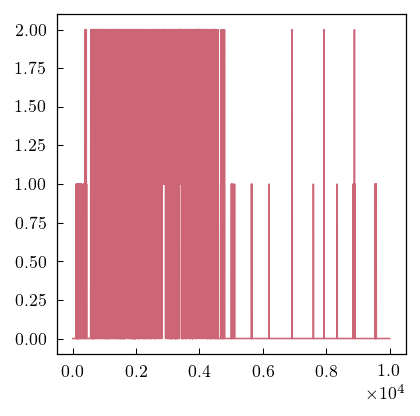

In [76]:
plt.plot(hbonds.count_by_time())

In [77]:
def hbond_anton_223(trajfile):
    u = mda.Universe("../../civsd-nowat.pdb", trajfile)
    r223_sel = "protein and resid 223 and not backbone and type N"
    phos_sel = "name O11 O12 O13 O14 and around 3.0 (protein and resid 223)"
    h_sel = "protein and resid 223 and name HE HH11 HH21 HH22 HH12"
    hbonds = HydrogenBondAnalysis(
        universe=u, 
        donors_sel=r223_sel, 
        hydrogens_sel=h_sel, 
        acceptors_sel=phos_sel,
        update_selections=True)
    return hbonds

In [78]:
dcd_analysis_ensemble = [hbond_anton_223(file) for file in dcds]

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [79]:
len(dcd_analysis_ensemble)

17

In [80]:
results_dcd_2 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in dcd_analysis_ensemble)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=40)]: Done   2 out of  17 | elapsed:  1.6min remaining: 11.9min
[Parallel(n_jobs=40)]: Done   3 out of  17 | elapsed:  1.6min remaining:  7.4min
[Parallel(n_jobs=40)]: Done   4 out of  17 | elapsed:  1.6min remaining:  5.2min
[Parallel(n_jobs=40)]: Done   5 out of  17 | elapsed:  1.6min remaining:  3.8min
[Parallel(n_jobs=40)]: Done   6 out of  17 | elapsed:  1.6min remaining:  2.9min
[Parallel(n_jobs=40)]: Done   7 out of  17 | elapsed:  1.6min remaining:  2.3min
[Parallel(n_jobs=40)]: Done   8 out of  17 | elapsed:  1.6min remaining:  1.8min
[Parallel(n_jobs=40)]: Done   9 out of  17 | elapsed:  1.6min remaining:  1.4min
[Parallel(n_jobs=40)]: Done  10 out of  17 | elapsed:  1.6min remaining:  1.1min
[Parallel(n_jobs=40)]: Done  11 out of  17 | elapsed:  1.6min remaining:   52.1s
[Parallel(n_jobs=40)]: Done  12 out of  17 | elapse

In [81]:
np.save("../../data/raw_feat/cv_hbond_r1P_anton2.npy", results_dcd_2)

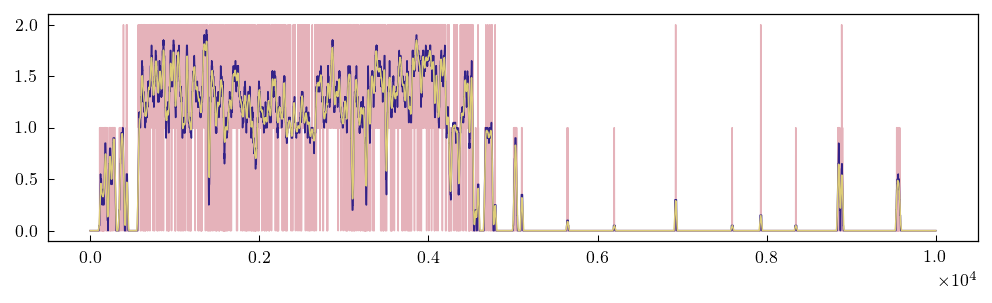

In [84]:
f = plt.figure(figsize=(8, 2))
plt.plot(results_dcd_2[0], alpha=0.5)
plt.plot(moving_average(results_dcd_2[0], 20))
plt.plot(moving_average(moving_average(results_dcd_2[0], 20), 20))
# plt.xlim([0, 500])

In [30]:
def hbond_anton_232(trajfile):
    u = mda.Universe("../../civsd-nowat.pdb", trajfile)
    r232_sel = "protein and resid 232 and not backbone and type N"
    phos_sel = "name O11 O12 O13 O14 and around 3.0 (protein and resid 232)"
    h_sel = "protein and resid 232 and name HE HH11 HH21 HH22 HH12"
    hbonds = HydrogenBondAnalysis(
        universe=u, 
        donors_sel=r232_sel, 
        hydrogens_sel=h_sel, 
        acceptors_sel=phos_sel,
        update_selections=True)
    return hbonds

In [28]:
dcds = [f"/project2/roux/scguo/ci-vsd/anton2/nowat/civsd.nowat.{i}.dcd" for i in range(3, 20)]

In [31]:
hb232_test = hbond_anton_232(dcds[0])

In [34]:
hb232 = run_analysis(hb232_test)

In [37]:
dcd_analysis_ensemble = [hbond_anton_232(file) for file in dcds]

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [ ]:
results_dcd_3 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in dcd_analysis_ensemble)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


In [ ]:
np.save("../../data/raw_feat/cv_hbond_r4P_anton2.npy", results_dcd_3)

# Plot against committors

In [4]:
hb0_trajs = np.load("../../data/raw_feat/cv_hbond_r0P_anton2.npy")
hb4_trajs = np.load("../../data/raw_feat/cv_hbond_r4P_anton2.npy")
hb1_trajs = np.load("../../data/raw_feat/cv_hbond_r1P_anton2.npy")

print(hb0_trajs.shape, hb4_trajs.shape, hb1_trajs.shape)

(17, 10001) (17, 10001) (17, 10001)


## Load data

In [5]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

In [6]:
weights = np.load("../../data/feat2_dist_du_anton2/weights.npy", allow_pickle=True)

In [7]:
q_downup = np.load("../../data/feat2_dist_du_anton2/q_downup.npy", allow_pickle=True)

In [8]:
cv_trajs = list(np.load('../../data/raw_feat/cv_dist_spin_anton.npy', allow_pickle=True))
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [9]:
sb_labels = []
for r in ('R217', 'R223', 'R226', 'R229', 'R232'):
    for n in ('D129', 'D136', 'D151', 'D164', 'E183', 'D186'):
        sb_labels.append(f'{r} - {n}')

In [10]:
sb_trajs = list(np.load('../../data/raw_feat/feat2_raw_anton.npy', allow_pickle=True))
# sb_trajs = []
# for i in range(6):
#     sb_trajs.extend(np.load(f'../../data/raw_feat/feat2_suppl_{i:02d}.npy', allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [11]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(3170017, 2) (3170017, 60)


In [12]:
random.seed(123)
s = 10
N = len(cv_arr)
inds = random.sample(range(N), N // s)

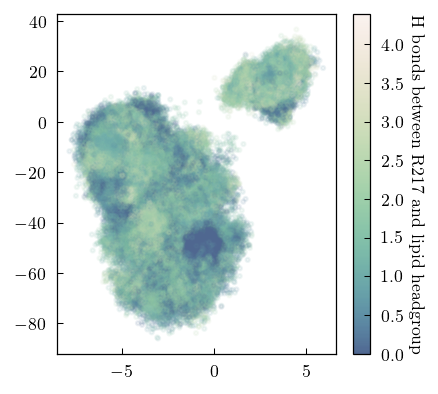

In [18]:
start = 3_000_000
hb_avg = np.concatenate(
    [moving_average(moving_average(traj, 10), 10) for traj in hb0_trajs]
)
sc = plt.scatter(cv_arr[start:, 0], cv_arr[start:, 1], c=hb_avg, alpha=0.1, cmap=cm_seq)
cb = plt.colorbar()
cb.solids.set(alpha=1.0)
cb.set_label("H bonds between R217 and lipid headgroup", rotation=-90, labelpad=10)

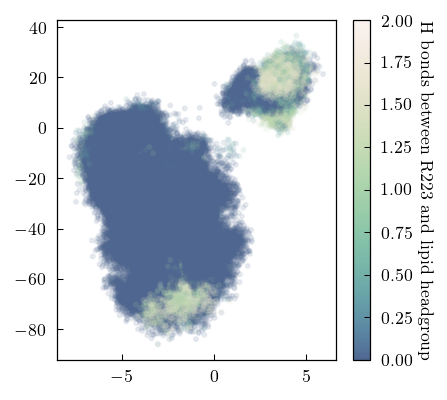

In [20]:
start = 3_000_000
hb1_avg = np.concatenate(
    [moving_average(moving_average(traj, 10), 10) for traj in hb1_trajs]
)
sc = plt.scatter(cv_arr[start:, 0], cv_arr[start:, 1], c=hb1_avg, alpha=0.1, cmap=cm_seq)
cb = plt.colorbar()
cb.solids.set(alpha=1.0)
cb.set_label("H bonds between R223 and lipid headgroup", rotation=-90, labelpad=10)

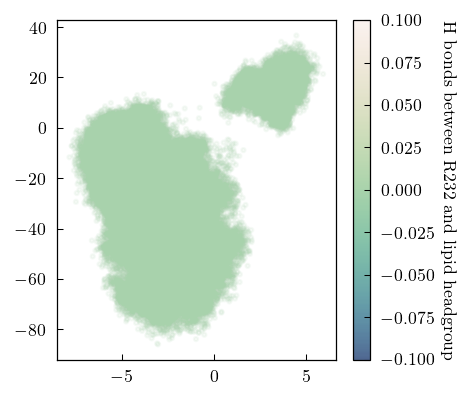

In [21]:
start = 3_000_000
hb4_avg = np.concatenate(
    [moving_average(moving_average(traj, 10), 10) for traj in hb4_trajs]
)
sc = plt.scatter(cv_arr[start:, 0], cv_arr[start:, 1], c=hb4_avg, alpha=0.1, cmap=cm_seq)
cb = plt.colorbar()
cb.solids.set(alpha=1.0)
cb.set_label("H bonds between R232 and lipid headgroup", rotation=-90, labelpad=10)

In [62]:
sb_ids = [42, 48, 47, 53]

In [64]:
sb_models = np.load("../../data/models_centroids_feat2.npy")

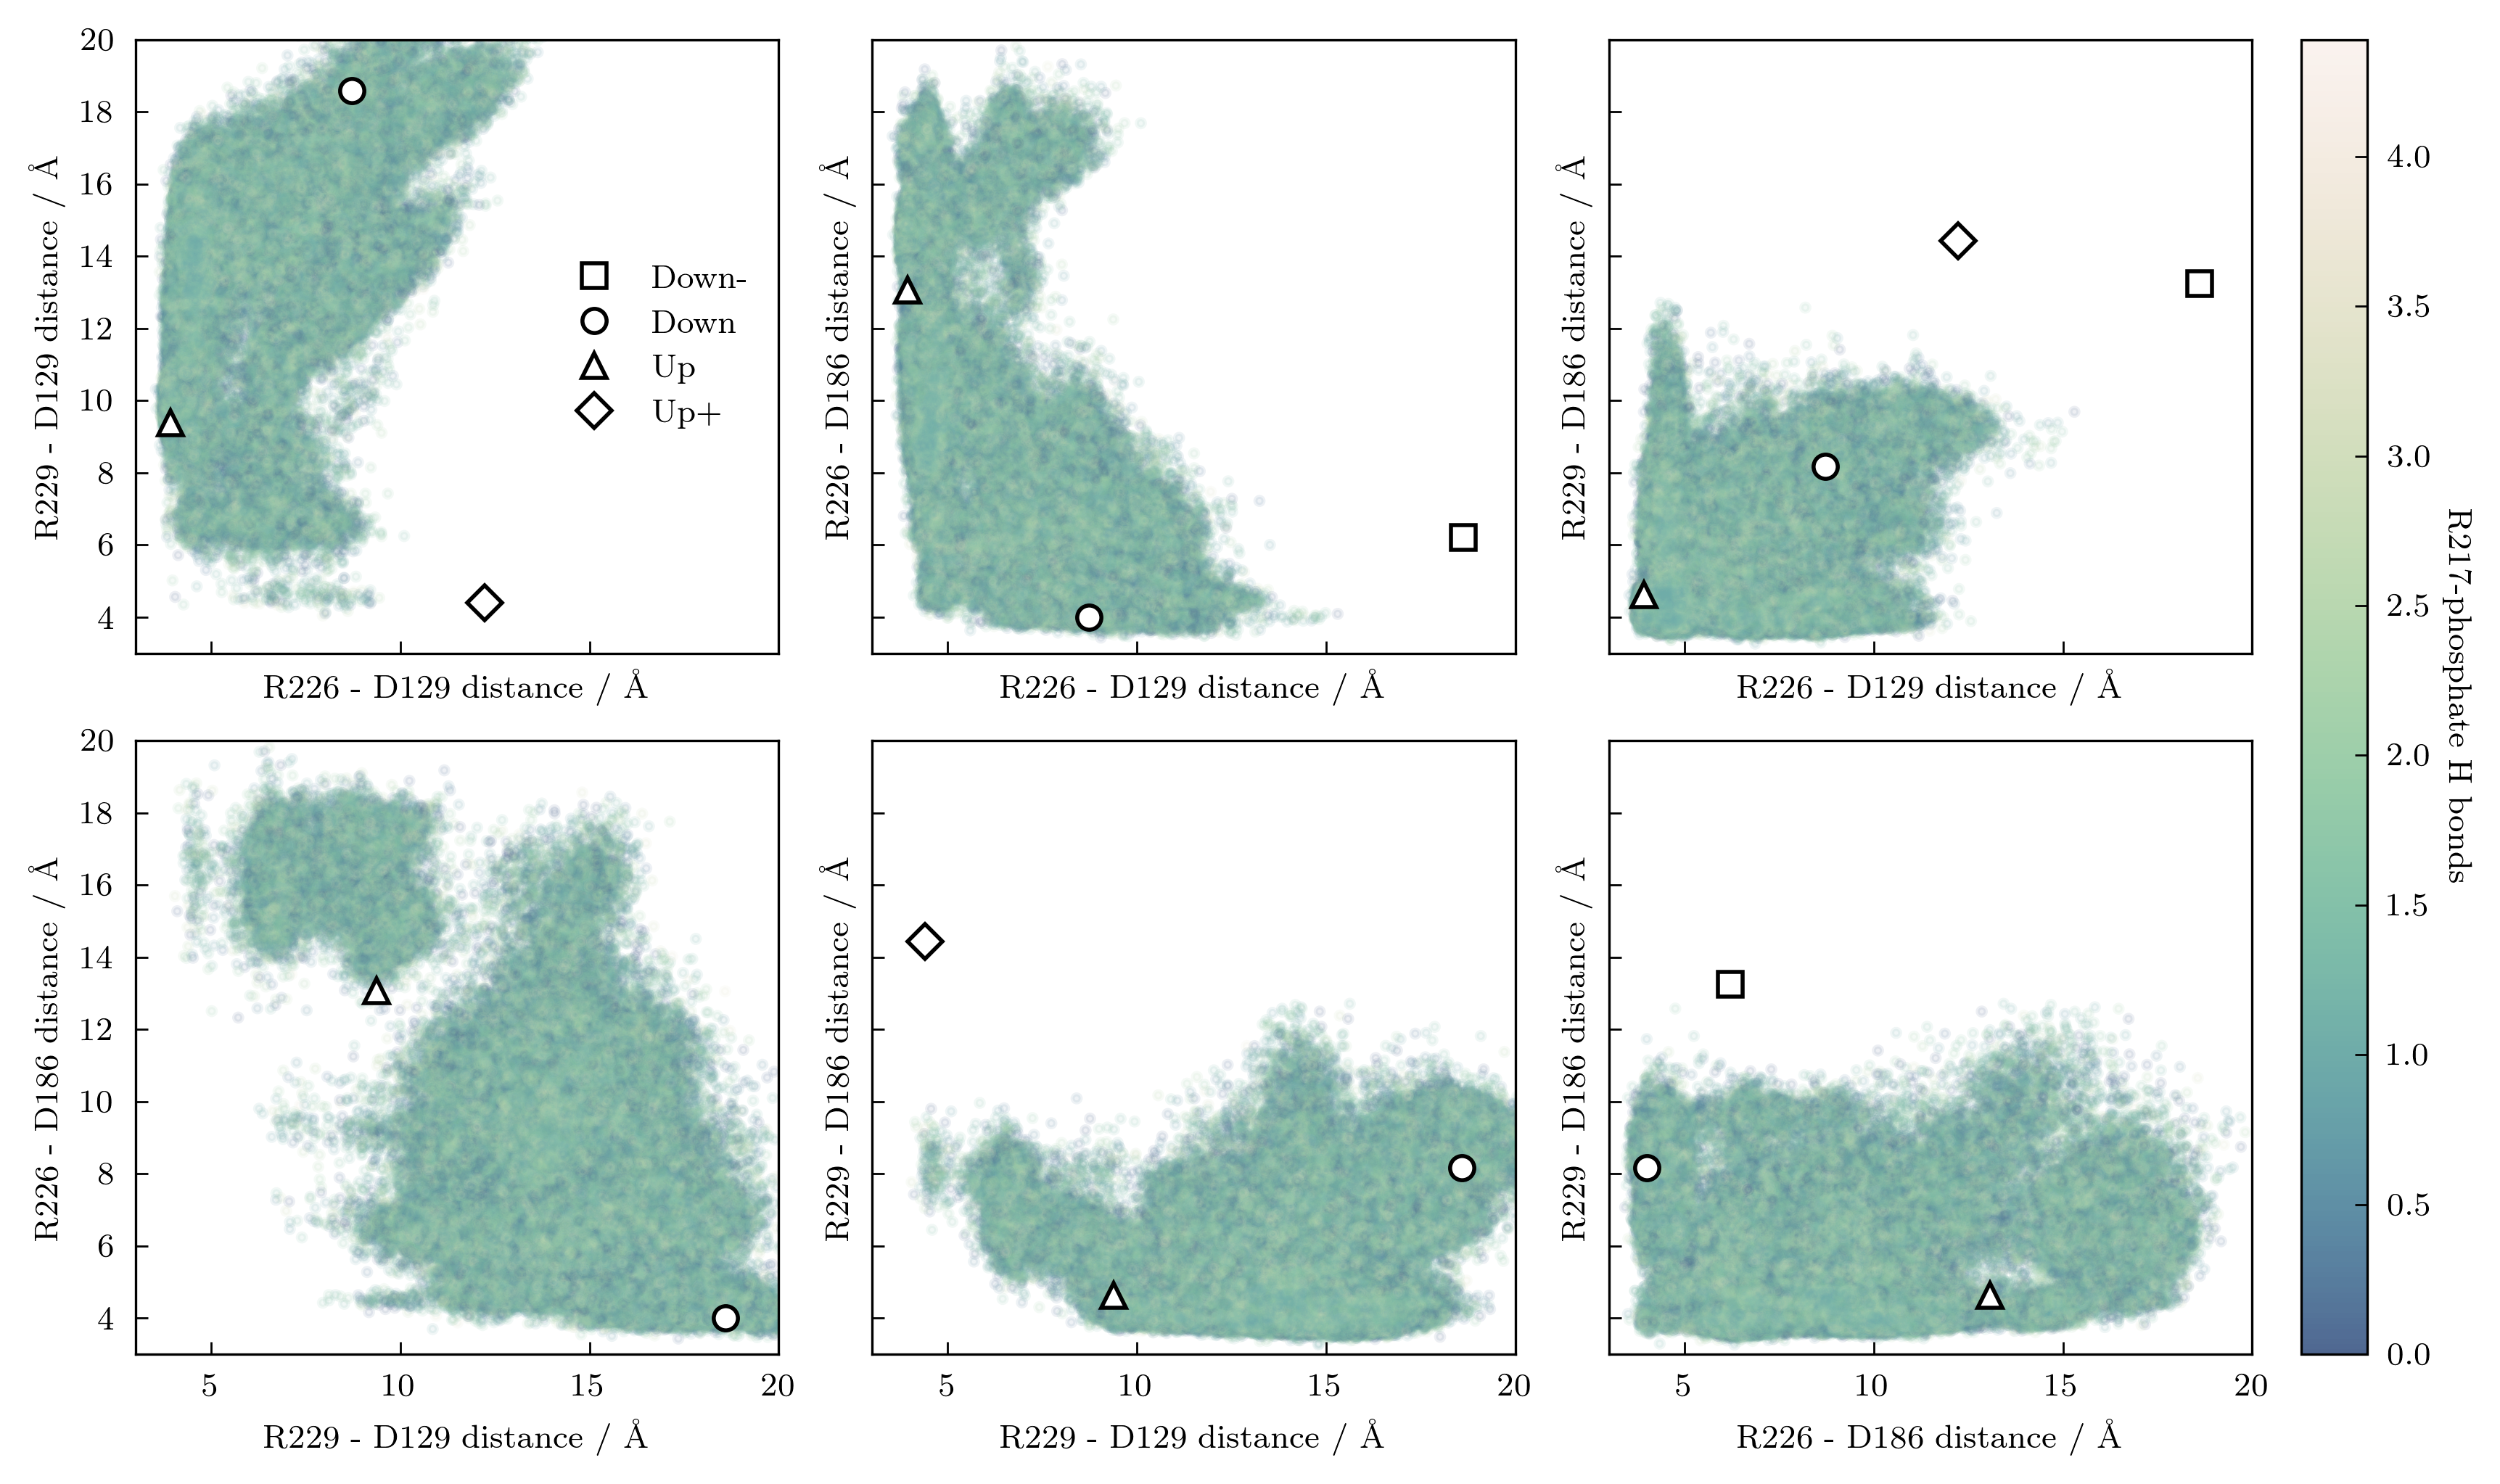

In [70]:
f, axes = plt.subplots(
    2, 3, figsize=(8.5, 5), dpi=400, sharex=True, sharey=True, constrained_layout=True)

# randomize indices
ids = np.arange(start, N)
random.shuffle(ids)
r = [[3, 20], [3, 20]]
for ((sb1, sb2), ax) in zip(combinations(sb_ids, 2), axes.flat):
    sc = ax.scatter(
        sb_arr[ids, sb1] * 10, 
        sb_arr[ids, sb2] * 10, 
        c=hb_avg, 
        alpha=0.1, 
        cmap=cm_seq)
    ax.set(
        xlabel=f"{sb_labels[sb1 - 30]} distance / Å", 
        ylabel=f"{sb_labels[sb2 - 30]} distance / Å",
        xlim=r[0],
        ylim=r[1]
    )
    
    plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=6)
    # ax.label_outer()

axes.flat[0].legend(loc='right')
cbar = f.colorbar(sc, ax=axes[:, -1])
cbar.solids.set(alpha=1)
cbar.set_label('R217-phosphate H bonds', rotation=-90, labelpad=10)